# Scratch notebook

This notebook contains scratch for the development of a new multi level graph architecture which comprises:

- A low-resolution grid (`LowResN`) which encodes the nodes of ERA5
- A high-resolution grid (`HighResN`) which encodes the nodes of GRIPHO
- Edges within the low-resolution grid (`LoResE`)
- Edges within the high-resolution grid (`HighResE`)
- Edges from the low-resolution nodes to the high-resolution nodes (`Low2HighE`)



In [1]:
from torch_geometric.data import HeteroData
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = HeteroData()

In [3]:
data

HeteroData()

## Scratch low-res and high-res grids to start playing

We start by defining some basic low-resolution and high-resolution grids to start playing and experimenting.

In [32]:
# low resolution nodes lon,lat coordinates
lon_low = torch.arange(0,11,1)
lat_low = torch.arange(0,11,1)

# high resolution nodes lon,lat coordinates
lon_high = torch.arange(0.1,10,0.2)
lat_high = torch.arange(0.1,10,0.2)

# low and high resolution nodes lon, lat coordinates (sorted)
lon_low_high = torch.cat((lon_high, lon_low),dim=0)
lat_low_high = torch.cat((lat_high, lat_low),dim=0)
lon_low_high, _ = torch.sort(lon_low_high)
lat_low_high, _ = torch.sort(lat_low_high)

# low, high, low and high coordinates in terms of meshgrid
lon_low_mesh, lat_low_mesh = torch.meshgrid(lon_low, lat_low, indexing='ij')
lon_high_mesh, lat_high_mesh = torch.meshgrid(lon_high, lat_high, indexing='ij')
lon_low_mesh = lon_low_mesh.flatten()
lat_low_mesh = lat_low_mesh.flatten()
lon_high_mesh = lon_high_mesh.flatten()
lat_high_mesh = lat_high_mesh.flatten()

lon_low_high_mesh = torch.cat((lon_low_mesh, lon_high_mesh),dim=0)
lat_low_high_mesh = torch.cat((lat_low_mesh, lat_high_mesh),dim=0)
# lon_high_low_mesh, lat_high_low_mesh = torch.meshgrid(lon_high_low, lat_high_low, indexing='ij')

In [33]:
low_res_nodes = np.logical_and(np.in1d(lon_low_high_mesh, lon_low_mesh),
                               np.in1d(lat_low_high_mesh, lat_low_mesh))

low_res_nodes.sum()

121

In [34]:
high_res_nodes = np.logical_and(np.in1d(lon_low_high_mesh, lon_high_mesh),
                               np.in1d(lat_low_high_mesh, lat_high_mesh)) 

In [35]:
high_res_nodes.sum()

2500

In [36]:
lon_low_high_mesh.shape

torch.Size([2621])

In [37]:
edge_index_high = np.empty((2,0), dtype=int)
LON_DIFF_MAX = 0.21
LAT_DIFF_MAX = 0.21

for ii, xi in enumerate(torch.concatenate((lon_high_mesh.unsqueeze(-1),
                                           lat_high_mesh.unsqueeze(-1)),dim=-1)):
    bool_lon = abs(lon_high_mesh - xi[0]) < LON_DIFF_MAX
    bool_lat = abs(lat_high_mesh - xi[1]) < LAT_DIFF_MAX
    bool_both = np.logical_and(bool_lon, bool_lat).bool()
    jj_list = np.flatnonzero(bool_both)
    xj_list = lat_high_mesh[bool_both]
    for jj, xj in zip(jj_list, xj_list):
        if not np.array_equal(xi, xj):
            edge_index_high = np.concatenate((edge_index_high, np.array([[ii], [jj]])), axis=-1, dtype=int)

edge_index_high = edge_index_high.swapaxes(0,1)

In [38]:
edge_index_low = np.empty((2,0), dtype=int)
LON_DIFF_MAX = 1.1
LAT_DIFF_MAX = 1.1

for ii, xi in enumerate(torch.concatenate((lon_low_mesh.unsqueeze(-1),
                                           lat_low_mesh.unsqueeze(-1)),dim=-1)):
    
    bool_lon = abs(lon_low_mesh - xi[0]) < LON_DIFF_MAX
    bool_lat = abs(lat_low_mesh - xi[1]) < LAT_DIFF_MAX
    bool_both = np.logical_and(bool_lon, bool_lat).bool()
    jj_list = np.flatnonzero(bool_both)
    xj_list = lat_low_mesh[bool_both]
    for jj, xj in zip(jj_list, xj_list):
        if not np.array_equal(xi, xj):
            edge_index_low = np.concatenate((edge_index_low, np.array([[ii], [jj]])), axis=-1, dtype=int)

edge_index_low = edge_index_low.swapaxes(0,1)

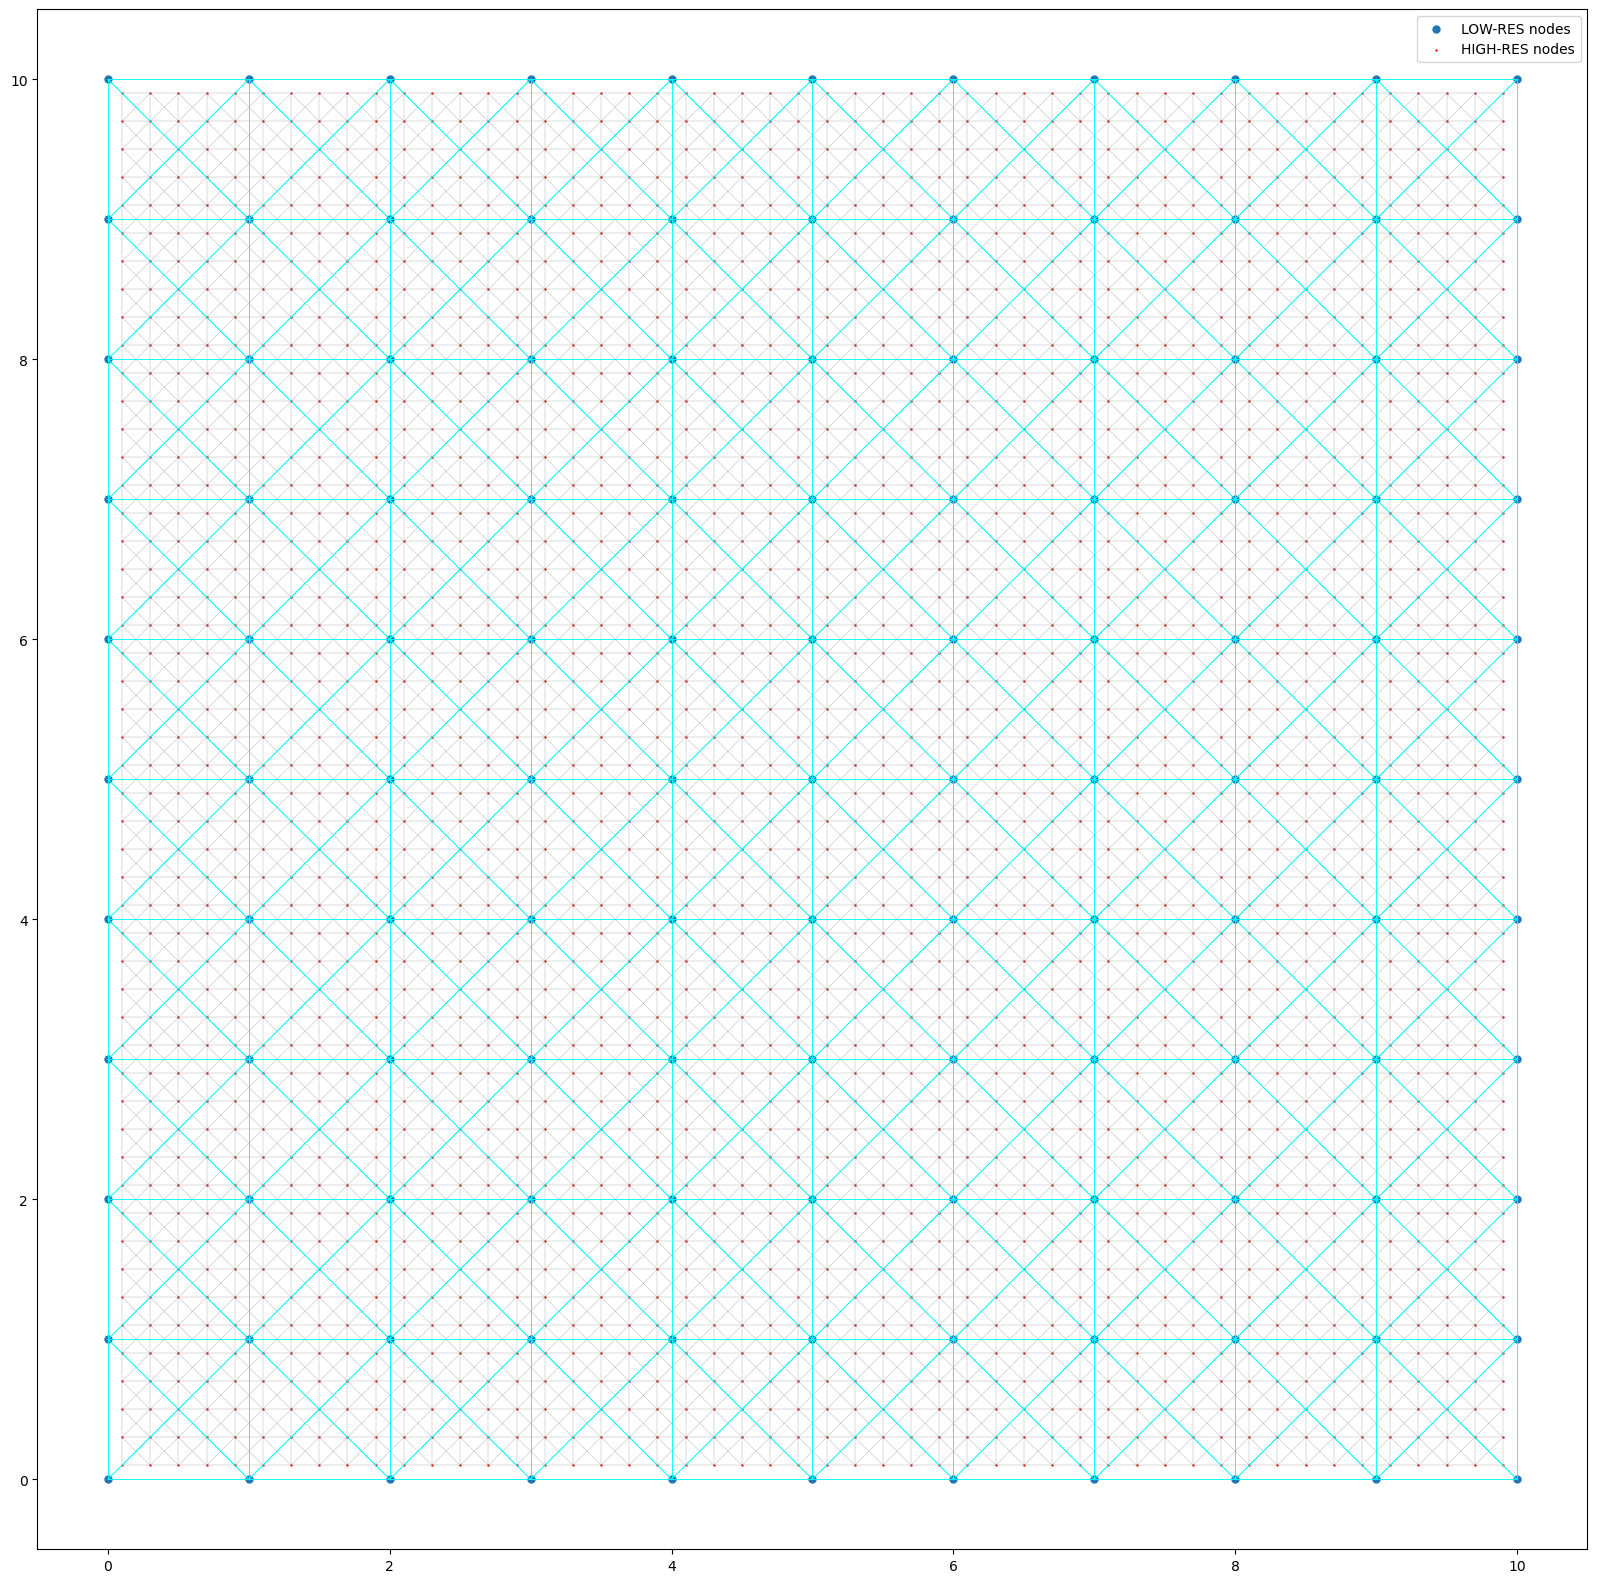

In [39]:
fig, ax = plt.subplots(figsize=(20,20))

for edge in edge_index_high:
    n1 = edge[0]
    n2 = edge[1]
    ax.plot([lon_high_mesh[n1], lon_high_mesh[n2]], [lat_high_mesh[n1],lat_high_mesh[n2]],
            linewidth=0.1, c='grey')
    
for edge in edge_index_low:
    n1 = edge[0]
    n2 = edge[1]
    ax.plot([lon_low_mesh[n1], lon_low_mesh[n2]], [lat_low_mesh[n1],lat_low_mesh[n2]],
            linewidth=0.5, c='cyan')
    
ax.scatter(lon_low_mesh, lat_low_mesh, s=25, label="LOW-RES nodes")
ax.scatter(lon_high_mesh, lat_high_mesh, s=0.5, c='r', label="HIGH-RES nodes")
plt.legend()
plt.show()

In [71]:
edge_index_low2high = []

LON_DIFF_MAX = 0.5
LAT_DIFF_MAX = 0.5

lonlat = torch.concatenate((lon_low_high_mesh.unsqueeze(-1), lat_low_high_mesh.unsqueeze(-1)),dim=-1)

for ii, xi in enumerate(lonlat):
    if low_res_nodes[ii]:
        # print(ii, ": yes!")
        bool_lon = abs(lon_low_high_mesh - xi[0]) < LON_DIFF_MAX
        bool_lat = abs(lat_low_high_mesh - xi[1]) < LAT_DIFF_MAX
        bool_both = torch.logical_and(bool_lon, bool_lat).bool() * torch.tensor(high_res_nodes).bool()
        jj_list = torch.nonzero(bool_both)
        xj_list = lonlat[bool_both,:]
        for jj, xj in zip(jj_list, xj_list):
            if high_res_nodes[jj]:
                if not torch.equal(xi, xj):
                    edge_index_low2high.append(torch.tensor([ii, jj]))

edge_index_low2high = torch.stack(edge_index_low2high)

In [72]:
edge_index_low2high.shape

torch.Size([1600, 2])

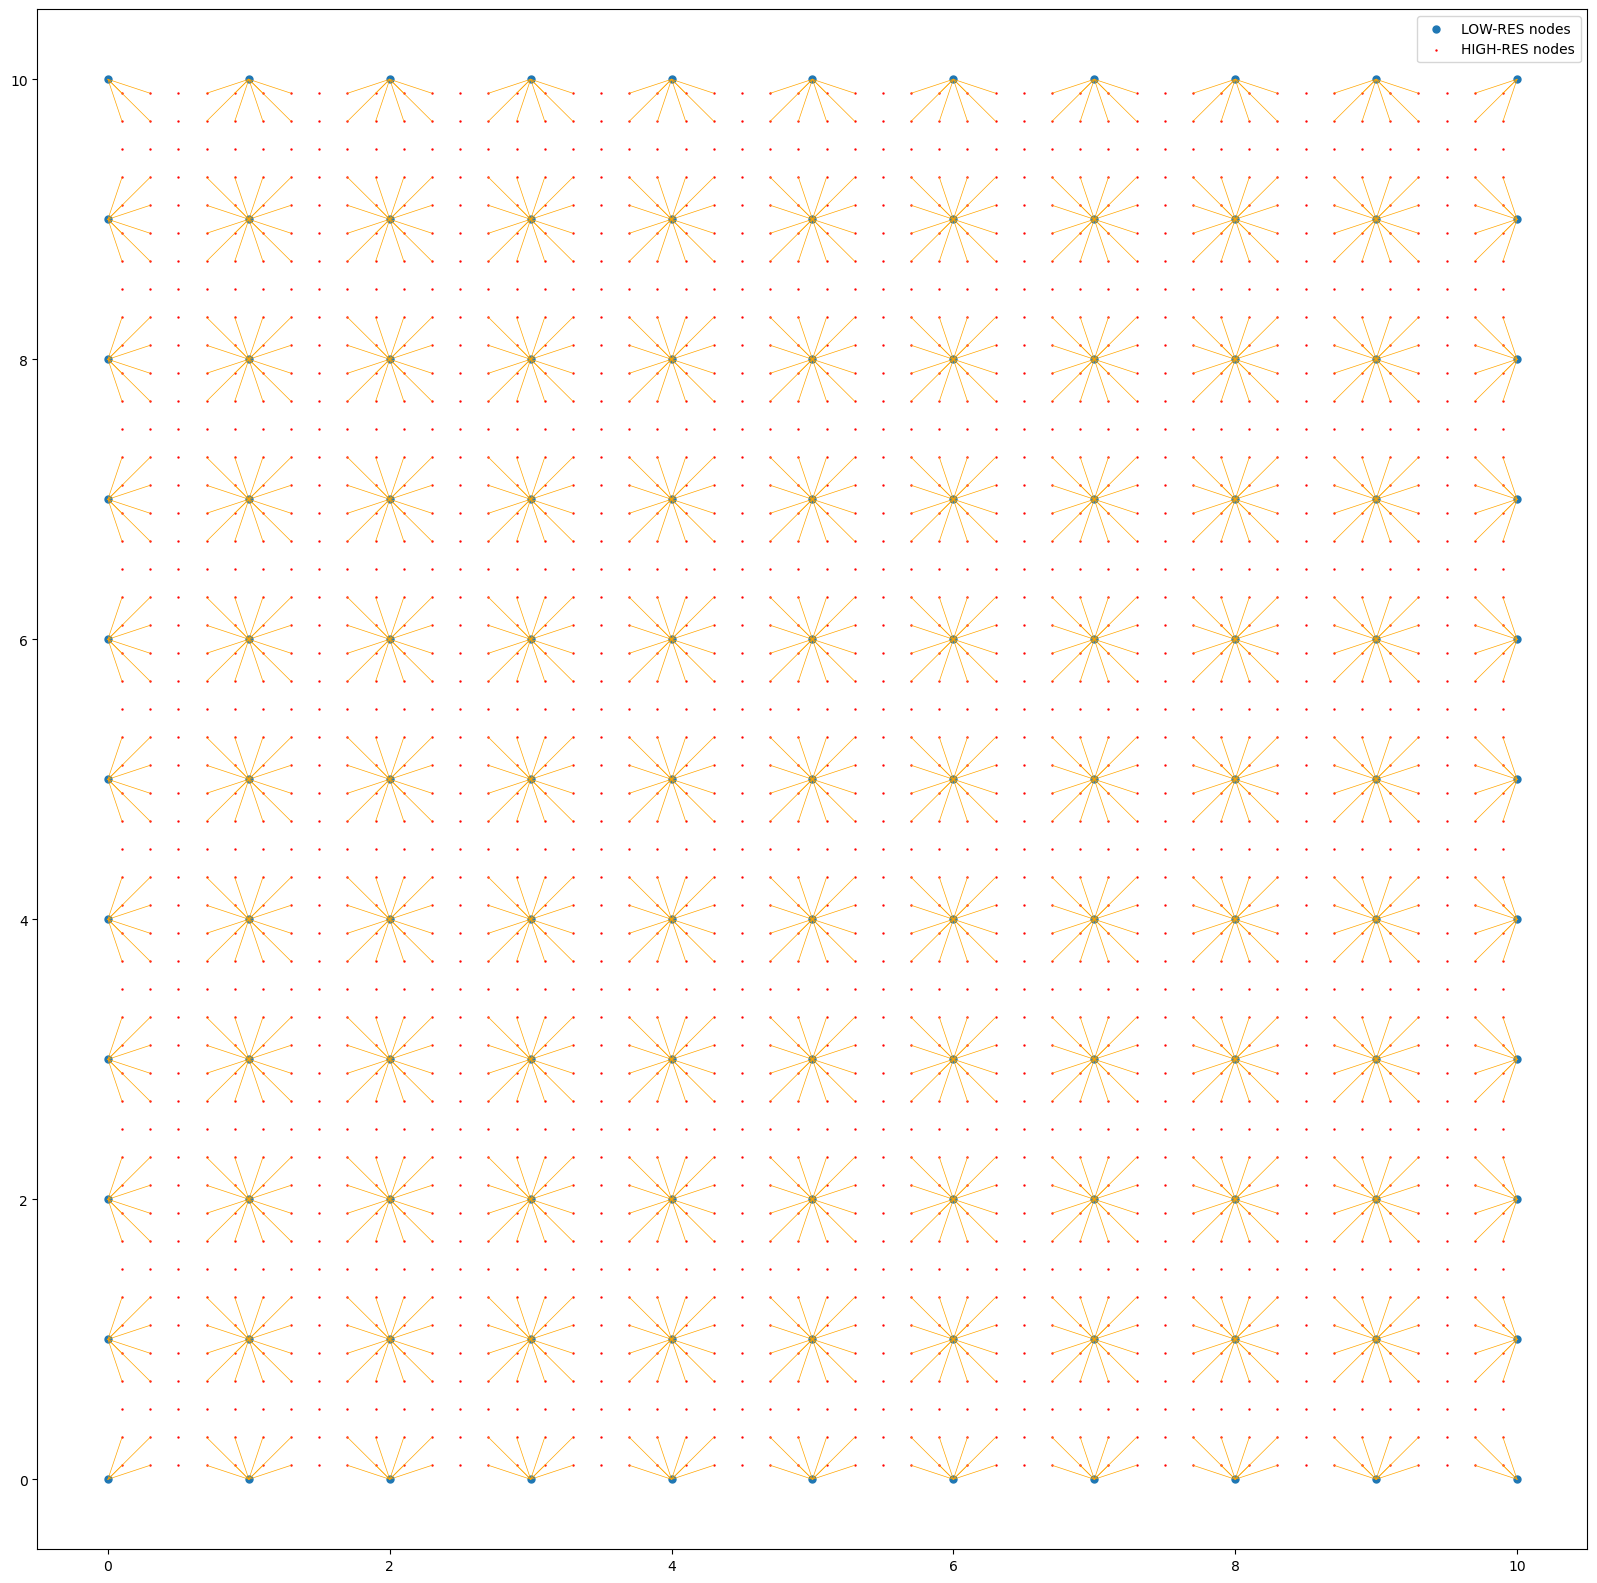

In [73]:
fig, ax = plt.subplots(figsize=(20,20))

for edge in edge_index_low2high:
    n1 = edge[0]
    n2 = edge[1]
    #print([lon_low_high_mesh[n1], lon_low_high_mesh[n2]], [lat_low_high_mesh[n1], lat_low_high_mesh[n2]])
    ax.plot([lon_low_high_mesh[n1], lon_low_high_mesh[n2]],
            [lat_low_high_mesh[n1], lat_low_high_mesh[n2]],
            linewidth=0.5, c='orange')

ax.scatter(lon_low_mesh, lat_low_mesh, s=25, label="LOW-RES nodes")
ax.scatter(lon_high_mesh, lat_high_mesh, s=0.5, c='r', label="HIGH-RES nodes")
plt.legend()
plt.show()